# Importing Packages

In [1]:
import pathlib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.python.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data Preprocessing

In [2]:
data_dir = pathlib.Path('C:/Users/Blake/Downloads/Shoes Dataset') # defining the path to the dataset

In [3]:
# splitting the dataset into a training set using TensorFlow's preprocessing function
training_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2, # 80% of the data will be used for training
    subset = 'training',
    seed = 123, # ensures random partitioning
    label_mode = 'categorical',
    image_size = (224, 224),
    batch_size = 64 # images to be processed at a time
)

Found 9280 files belonging to 5 classes.
Using 7424 files for training.


In [4]:
# splitting the dataset into a validation set using TensorFlow's preprocessing function
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2, # 20% of the data will be used for validating
    subset = 'validation',
    seed = 123, # having the same random seed ensures samples don't appear in both sets
    label_mode = 'categorical',
    image_size = (224, 224),
    batch_size = 64 # images to be processed at a time
)

Found 9280 files belonging to 5 classes.
Using 1856 files for validation.


# Model Architecture

In [5]:
class_labels = training_set.class_names # getting the class labels of the dataset

In [6]:
mobilenet_model = Sequential() # creating a sequential model

# loading a pre-trained MobileNetV2 model
pretrained_model = tf.keras.applications.MobileNetV2(
    include_top = False, # excluding the final classification layer of the original model
    input_shape = (224, 224, 3), # expected input image shape (224x224 pixels and 3 colour schemes - RGB)
    pooling = 'avg', # global average pooling layer for feature aggregation
    classes = len(class_labels), # number of output classes to be expected
    weights = 'imagenet' # initialise the pre-trained weights from the ImageNet dataset
)

# setting all layers in the pre-trained model to be non-trainable helps reduce training time
for layer in pretrained_model.layers:
    layer.trainable = False

mobilenet_model.add(pretrained_model) # adding the pre-trained MobileNetV2 model to the custom sequential model
mobilenet_model.add(Flatten()) # transforms the 2D feature maps to a 1D vector
mobilenet_model.add(Dense(512, activation = 'relu')) # add 512 neurons and ReLU activation for feature transformation
mobilenet_model.add(Dropout(0.5)) # add dropout layer for regularisation to prevent overfitting
mobilenet_model.add(Dense(len(class_labels), activation = 'softmax')) # add a neuron for each output class and softmax activation for classification

In [7]:
# compile the model
mobilenet_model.compile(
    optimizer = Adam(learning_rate = 0.001), # Adam optimiser and a learning rate of 0.001 for gradient descent
    loss = 'categorical_crossentropy', # compile the model with the categorical cross entropy loss function for multi-class classification
    metrics = ['accuracy'] # compile the model with the accuracy metric to monitor performance during training
)

In [8]:
# defining a learning rate schedule
def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# gradually decreases the learning rate each epoch after the 5th epoch
lr_scheduler = LearningRateScheduler(lr_schedule)

# stops fine-tuning the model if the validation loss increases for 5 epochs straight
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)

# saves the best model during training
best_model_checkpoint = ModelCheckpoint(
    'best_mobilenet_model', # name of save 
    monitor = 'val_accuracy', # checkpoint criteria
    save_best_only = True, # saves the model with the highest validation accuracy
    save_weights_only = False, # saves the entire model
    save_format = 'tf' # saves the model as a Keras SavedModel format
)

# Fine-Tuning Model

In [9]:
# fine-tuning the model and storing training history
history = mobilenet_model.fit(
    training_set, # fine-tune the model on the training set
    validation_data = validation_set, # validate the model
    epochs = 10, # run over the training and validation sets 10 times
    callbacks = [lr_scheduler, early_stopping, best_model_checkpoint] # applying callbacks to model's fine-tuning
)

Epoch 1/10
116/116 [==============================] - ETA: 0s - loss: 0.4058 - accuracy: 0.8534

INFO:tensorflow:Assets written to: best_mobilenet_model\assets


INFO:tensorflow:Assets written to: best_mobilenet_model\assets


116/116 [==============================] - 451s 4s/step - loss: 0.4058 - accuracy: 0.8534 - val_loss: 0.0875 - val_accuracy: 0.9790 - lr: 0.0010
Epoch 2/10
116/116 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9657

INFO:tensorflow:Assets written to: best_mobilenet_model\assets


INFO:tensorflow:Assets written to: best_mobilenet_model\assets


116/116 [==============================] - 439s 4s/step - loss: 0.1078 - accuracy: 0.9657 - val_loss: 0.0598 - val_accuracy: 0.9811 - lr: 0.0010
Epoch 3/10
116/116 [==============================] - ETA: 0s - loss: 0.0682 - accuracy: 0.9776INFO:tensorflow:Assets written to: best_mobilenet_model\assets


INFO:tensorflow:Assets written to: best_mobilenet_model\assets


116/116 [==============================] - 420s 3s/step - loss: 0.0682 - accuracy: 0.9776 - val_loss: 0.0496 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 4/10
116/116 [==============================] - 418s 3s/step - loss: 0.0484 - accuracy: 0.9850 - val_loss: 0.0689 - val_accuracy: 0.9768 - lr: 0.0010
Epoch 5/10
116/116 [==============================] - ETA: 0s - loss: 0.0347 - accuracy: 0.9898INFO:tensorflow:Assets written to: best_mobilenet_model\assets


INFO:tensorflow:Assets written to: best_mobilenet_model\assets


116/116 [==============================] - 441s 4s/step - loss: 0.0347 - accuracy: 0.9898 - val_loss: 0.0269 - val_accuracy: 0.9903 - lr: 0.0010
Epoch 6/10
116/116 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9934INFO:tensorflow:Assets written to: best_mobilenet_model\assets


INFO:tensorflow:Assets written to: best_mobilenet_model\assets


116/116 [==============================] - 428s 4s/step - loss: 0.0256 - accuracy: 0.9934 - val_loss: 0.0247 - val_accuracy: 0.9919 - lr: 9.0484e-04
Epoch 7/10
116/116 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9949INFO:tensorflow:Assets written to: best_mobilenet_model\assets


INFO:tensorflow:Assets written to: best_mobilenet_model\assets


116/116 [==============================] - 430s 4s/step - loss: 0.0189 - accuracy: 0.9949 - val_loss: 0.0182 - val_accuracy: 0.9925 - lr: 8.1873e-04
Epoch 8/10
116/116 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9958INFO:tensorflow:Assets written to: best_mobilenet_model\assets


INFO:tensorflow:Assets written to: best_mobilenet_model\assets


116/116 [==============================] - 447s 4s/step - loss: 0.0168 - accuracy: 0.9958 - val_loss: 0.0168 - val_accuracy: 0.9946 - lr: 7.4082e-04
Epoch 9/10
116/116 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9956INFO:tensorflow:Assets written to: best_mobilenet_model\assets


INFO:tensorflow:Assets written to: best_mobilenet_model\assets


116/116 [==============================] - 441s 4s/step - loss: 0.0151 - accuracy: 0.9956 - val_loss: 0.0141 - val_accuracy: 0.9941 - lr: 6.7032e-04
Epoch 10/10
116/116 [==============================] - 421s 3s/step - loss: 0.0108 - accuracy: 0.9973 - val_loss: 0.0154 - val_accuracy: 0.9946 - lr: 6.0653e-04


# Model Evaluation

In [10]:
# accessing the history object to get loss and accuracy values across each epoch
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

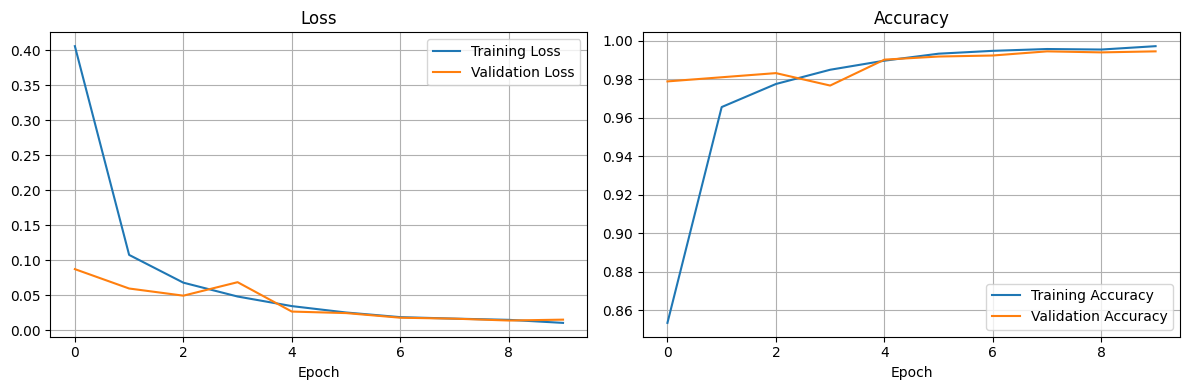

In [11]:
# creating subplots for loss and accuracy metrics
plt.figure(figsize = (12, 4))

# plotting training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.grid(True)

# plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)

# displaying the plots
plt.tight_layout()
plt.show()

In [12]:
# importing the best MobileNet model
best_mobilenet_model = tf.keras.models.load_model('best_mobilenet_model')

In [13]:
# initialising lists to store true and predicted labels
true_labels = []
predicted_labels = []

# defining the path to the test images
test_dir = 'C:/Users/Blake/Downloads/Shoes Test'

# mapping the test image prefixes to actual class labels
class_mapping = {
    'A': 'Adidas Continental 80 Sneaker',
    'C': 'Converse Distrito 2.0 Canvas Low Sneaker',
    'NBW': 'Nike Low Dunk Black and White',
    'NC': 'Nike Low Dunk Medium Curry',
    'UA': 'Under Armour Ripple 2.0 Sneaker'
}

# loop through each image in the test directory
for filename in os.listdir(test_dir):
    if filename.endswith('.JPG'):
        # load and preprocess image
        image = cv2.imread(os.path.join(test_dir, filename))
        image_resized = cv2.resize(image, (224, 224))
        image = np.expand_dims(image_resized, axis = 0)

        # make prediction
        prediction = best_mobilenet_model.predict(image)
        predicted_class = class_labels[np.argmax(prediction)]

        # extract the true class label from the filename
        prefix = filename.split('_')[0]
        true_class = class_mapping.get(prefix, 'Unknown')

        # append the true and predicted labels to the lists
        true_labels.append(true_class)
        predicted_labels.append(predicted_class)

1/1 [==============================] - 0s 49ms/step


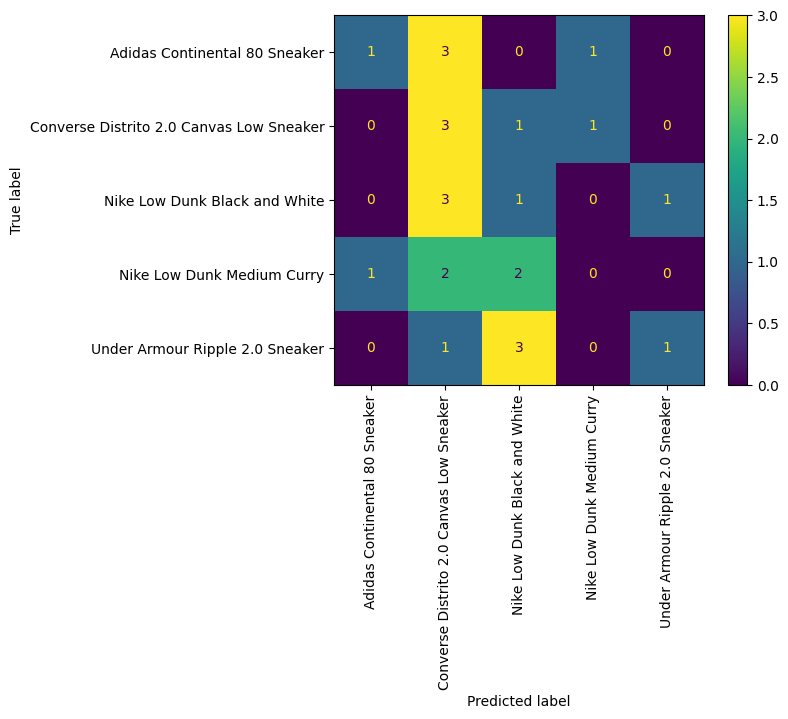

In [14]:
# creating a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels = class_labels)

# displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_labels)
disp.plot(cmap = 'viridis', xticks_rotation = 'vertical')
plt.show()

# Converting Model

In [15]:
# converting the Keras model to TensorFlow Lite (TFLite) format
converter = tf.lite.TFLiteConverter.from_keras_model(best_mobilenet_model)
tflite_mobilenet_model = converter.convert()

# saving the TFLite model to a file
with open ('best_mobilenet_model.tflite', 'wb') as f:
  f.write(tflite_mobilenet_model)

INFO:tensorflow:Assets written to: C:\Users\Blake\AppData\Local\Temp\tmpq0szxyau\assets


INFO:tensorflow:Assets written to: C:\Users\Blake\AppData\Local\Temp\tmpq0szxyau\assets
